# Data cleaning with Pandas

A large part of working with digital data is making sure that it is clean. There are numerous things that this commonly involves (in no particular order, and non-exhaustively):
* parsing dates
* normalising strings
* unit conversions
* identifying missing data
* inferring/recreating missing data
* confirming data types
* ensuring values are 'sane' (negative densities, for example)

We are going to load and clean well data from the Panoma Field, in Texas' Permian Basin. We will then take that cleaned data and create a dataset that we can take forward into the machine learning course.

### Instructor notes

First show some aggregate/summary functions, then go through each column and identify what might be wrong. Not all of them have problems, but many do. Show solutions to the first couple, and then give students time to fix the others.

Depending on the level of pandas comfort and familiarity of the class, some introductory material might be needed. Use `Intro_to_pands` if it is.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Reading our data

It is not much code to load a sensible Excel (`.xlsx`) file as a DataFrame:

In [4]:
df = pd.read_excel('https://geocomp.s3.amazonaws.com/data/Panoma_Field_Permian-RAW.xlsx', sheet_name='data')
df.head()

,Well Name,Depth,Formation,RelPos,Marine,GR,ILD,DeltaPHI,PHIND,PE,Facies,Completion Date,Index,Source
0,SHRIMPLIN,851.3064,A1 SH,1.000,1,77.45,4.613176,9.9,11.915,4.6,Nonmarine fine siltstone,2010-03-26,63,KGS
1,SHRIMPLIN,851.4588,A1 SH,0.979,1,78.26,4.581419,14.2,12.565,4.1,Nonmarine fine siltstone,2010-03-26,64,KGS
2,SHRIMPLIN,851.6112,A1 SH,0.957,1,79.05,4.549881,14.8,13.050,3.6,Nonmarine fine siltstone,2010-03-26,65,KGS
3,SHRIMPLIN,851.7636,A1 SH,0.936,1,86.10,4.518559,13.9,13.115,3.5,Nonmarine fine siltstone,2010-03-26,66,KGS
4,SHRIMPLIN,851.9160,A1 SH,0.915,1,74.58,4.436086,13.5,13.300,3.4,Nonmarine fine siltstone,2010-03-26,67,KGS


We can also load this from a CSV:

```python
df = pd.read_csv('https://geocomp.s3.amazonaws.com/data/Panoma_Field_Permian_RAW.csv')
```

If we have a sqlite db, we can load that as well. Connecting to a 'real' SQL database might need sqlalchemy, but looks pretty similar from the pandas side.

In [2]:
from sqlite3 import connect

In [3]:
connection = connect('../data/panoma.db')
sql_command = '''SELECT *
FROM panoma_raw
'''

pd.read_sql(sql_command, con=connection)

,index,Well Name,Depth,Formation,RelPos,Marine,GR,ILD,DeltaPHI,PHIND,PE,Facies,Completion Date,Source
0,0,SHRIMPLIN,851.3064,A1 SH,1.000,0,77.450,4.6132,9.900,11.915,4.600,Nonmarine fine siltstone,2010-03-26 00:00:00,KGS
1,1,SHRIMPLIN,851.4588,A1 SH,0.979,0,78.260,4.5814,14.200,12.565,4.100,Nonmarine fine siltstone,2010-03-26 00:00:00,KGS
2,2,SHRIMPLIN,851.6112,A1 SH,0.957,0,79.050,4.5499,14.800,13.050,3.600,Nonmarine fine siltstone,2010-03-26 00:00:00,KGS
3,3,SHRIMPLIN,851.7636,A1 SH,0.936,0,86.100,4.5186,13.900,13.115,3.500,Nonmarine fine siltstone,2010-03-26 00:00:00,KGS
4,4,SHRIMPLIN,851.9160,A1 SH,0.915,0,74.580,4.4361,13.500,13.300,3.400,Nonmarine fine siltstone,2010-03-26 00:00:00,KGS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3968,4894,CRAWFORD,962.7108,C SH,0.639,0,86.078,3.5810,5.040,16.150,3.161,Nonmarine coarse siltstone,2001-08-19 00:00:00,KGS
3969,4895,CRAWFORD,962.8632,C SH,0.611,0,88.855,3.4594,5.560,16.750,3.118,Nonmarine coarse siltstone,2001-08-19 00:00:00,KGS
3970,4896,CRAWFORD,963.0156,C SH,0.583,0,90.490,3.3884,6.360,16.780,3.168,Nonmarine coarse siltstone,2001-08-19 00:00:00,KGS
3971,4897,CRAWFORD,963.1680,C SH,0.556,0,90.975,3.3266,7.035,16.995,3.154,Nonmarine coarse siltstone,2001-08-19 00:00:00,KGS


Using SQL lets us get much more complex with what we actually load, so it might be a good option if you have a lot of data, or only want specific things.

In [4]:
sql_command = '''SELECT gr, ild, pe
FROM panoma_raw
WHERE [Well Name] IS 'CRAWFORD' AND depth > 960 AND marine == 1
'''

pd.read_sql(sql_command, con=connection)

,GR,ILD,PE
0,79.722,5.9020,4.040
1,76.334,6.3096,3.997
2,73.631,6.3096,3.828
3,76.865,5.9156,3.535


We can then look at our data as a whole with various summary views of the dataset.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4899 entries, 0 to 4898
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Well Name        4899 non-null   object 
 1   Depth            4899 non-null   float64
 2   Formation        4899 non-null   object 
 3   RelPos           4899 non-null   float64
 4   Marine           4899 non-null   int64  
 5   GR               4899 non-null   float64
 6   ILD              4899 non-null   float64
 7   DeltaPHI         4899 non-null   float64
 8   PHIND            4899 non-null   float64
 9   PE               3994 non-null   float64
 10  Facies           4878 non-null   object 
 11  Completion Date  4899 non-null   object 
 12  Index            4899 non-null   int64  
 13  Source           4899 non-null   object 
dtypes: float64(7), int64(2), object(5)
memory usage: 536.0+ KB


In [7]:
df.describe()

,Depth,RelPos,Marine,GR,ILD,DeltaPHI,PHIND,PE,Index
count,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,4899.000000,3994.000000,4899.000000
mean,1062.765370,0.525186,1.368238,64.045812,5.502804,4.175661,11.857880,3.680742,2512.000000
std,1572.767046,0.286708,0.584560,29.864569,4.016967,5.071942,7.744424,0.820622,1414.363815
min,-3057.000000,0.000000,0.000000,10.149000,0.340408,-21.832000,0.025500,0.200000,63.000000
25%,848.944200,0.281500,1.000000,44.060500,3.198895,1.364500,7.150000,3.118250,1287.500000
50%,907.237200,0.531000,1.000000,64.470000,4.415704,3.955000,11.310000,3.505000,2512.000000
75%,2801.250000,0.774000,2.000000,78.755000,6.753055,7.041000,15.392500,4.238250,3736.500000
max,3160.500000,1.000000,2.000000,361.150000,63.095734,19.312000,84.400000,8.094000,4961.000000


In [8]:
df.shape

(4899, 14)

In [9]:
df.columns

Index(['Well Name', 'Depth', 'Formation', 'RelPos', 'Marine', 'GR', 'ILD',
       'DeltaPHI', 'PHIND', 'PE', 'Facies', 'Completion Date', 'Index',
       'Source'],
      dtype='object')

#### `missingno`

Missingno is another python library that can give you a quick overview of null data within a dataframe.

In [10]:
import missingno

<AxesSubplot:>

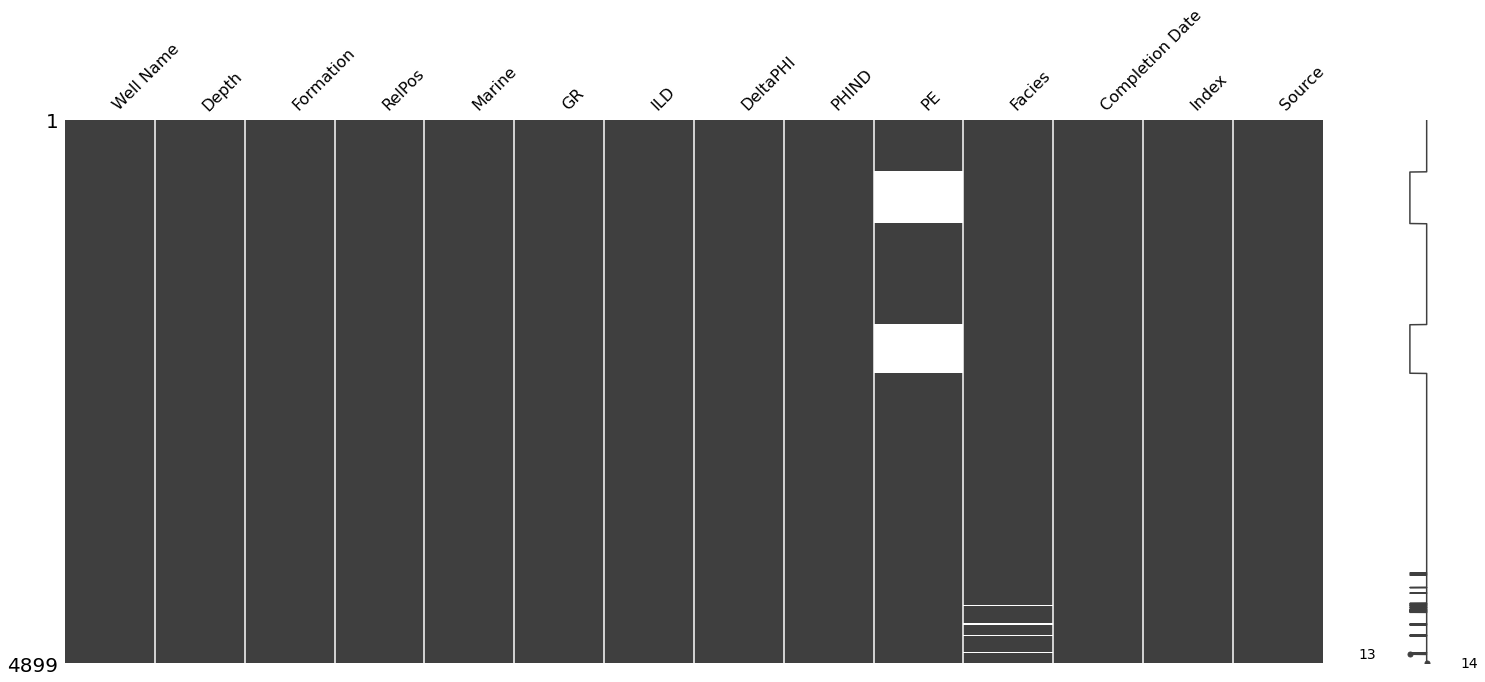

In [11]:
missingno.matrix(df)

## Column by Column

We are going to go through each of these columns and see if there are problems with the data in that column. If there are, we will look at how we might fix them. Get your coding gloves on!

### `Index`

<AxesSubplot:>

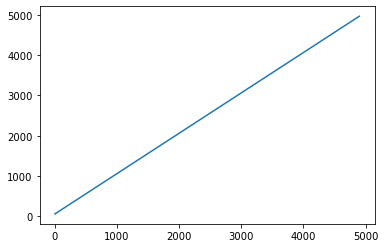

In [12]:
df['Index'].plot()

In [13]:
df.drop(columns=['Index'], inplace=True)

### `Well Name`

In [14]:
df['Well Name'].unique()

array(['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A',
       'CROSS H. CATTLE', 'CROSS H CATTLE', 'NOLAN', 'NEWBY',
       'CHURCHMAN BIBLE', 'STUART', 'CRAWFORD'], dtype=object)

In [15]:
df['Well Name'] = df['Well Name'].str.replace('.', '', regex=False)
df['Well Name'].unique()

array(['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A',
       'CROSS H CATTLE', 'NOLAN', 'NEWBY', 'CHURCHMAN BIBLE', 'STUART',
       'CRAWFORD'], dtype=object)

### `Formation`

In [22]:
df['Formation'].unique()

array(['A1 SH', 'A1 LM', 'B1 SH', 'B1 LM', 'B2 SH', 'B2 LM', 'B3 SH',
       'B3 LM', 'B4 SH', 'B4 LM', 'B5 SH', 'B5 LM', 'C SH', 'C LM',
       'A1 Shale', 'A1 Limestone', 'B1 Shale', 'B1 Limestone', 'B2 Shale',
       'B2 Limestone', 'B3 Shale', 'B3 Limestone', 'B4 Shale',
       'B4 Limestone', 'B5 Shale', 'B5 Limestone', 'C Shale',
       'C Limestone'], dtype=object)

In [23]:
df['Formation'] = df['Formation'].str.replace('Shale', 'SH')
df['Formation'] = df['Formation'].str.replace('Limestone', 'LM')
df['Formation'].unique()

array(['A1 SH', 'A1 LM', 'B1 SH', 'B1 LM', 'B2 SH', 'B2 LM', 'B3 SH',
       'B3 LM', 'B4 SH', 'B4 LM', 'B5 SH', 'B5 LM', 'C SH', 'C LM'],
      dtype=object)

### `RelPos`

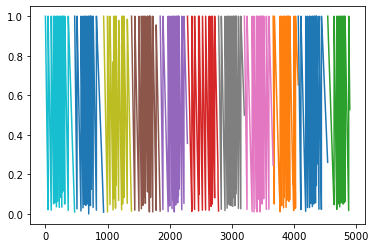

In [24]:
for name, grp in df.groupby('Well Name'):
    grp['RelPos'].plot()

<AxesSubplot:xlabel='RelPos', ylabel='Depth'>

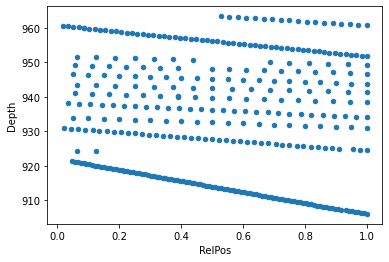

In [25]:
df.loc[df['Well Name'] == 'CRAWFORD', ['RelPos', 'Depth']].plot(x='RelPos', y='Depth', kind='scatter')

### `Marine`

In [26]:
df['Marine'].unique()

array([1, 2, 0], dtype=int64)

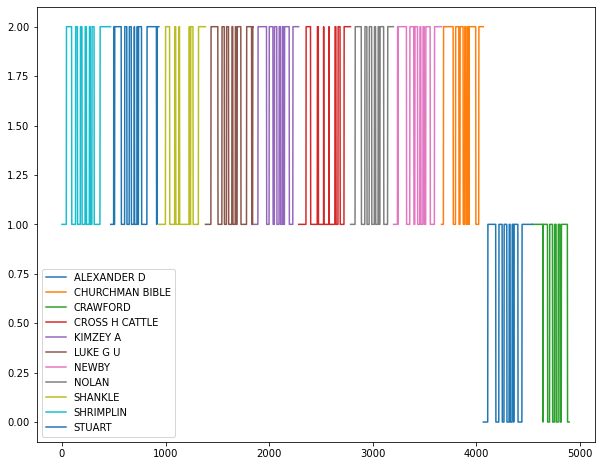

In [27]:
for name, grp in df.groupby('Well Name'):
    grp['Marine'].plot(label=name, legend=True, figsize=(10,8))

In [28]:
to_fix = df['Well Name'].unique()[:-2]
to_fix

array(['SHRIMPLIN', 'ALEXANDER D', 'SHANKLE', 'LUKE G U', 'KIMZEY A',
       'CROSS H CATTLE', 'NOLAN', 'NEWBY', 'CHURCHMAN BIBLE'],
      dtype=object)

In [29]:
df.loc[df['Well Name'].isin(to_fix), 'Marine'] = df['Marine'] - 1

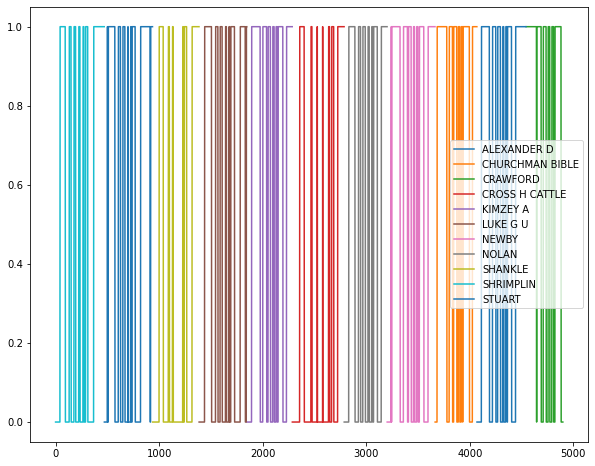

In [30]:
for name, grp in df.groupby('Well Name'):
    grp['Marine'].plot(label=name, legend=True, figsize=(10,8))

In [32]:
df['Marine'].dtype

dtype('int64')

<AxesSubplot:xlabel='Marine'>

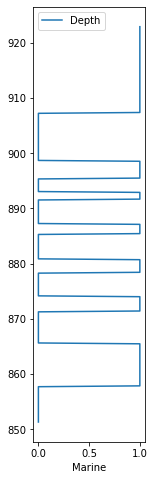

In [33]:
df.loc[df['Well Name'] == 'SHRIMPLIN', ['Depth', 'Marine']].plot(x='Marine', y='Depth', figsize=(2,8))

### `Depth`

<AxesSubplot:>

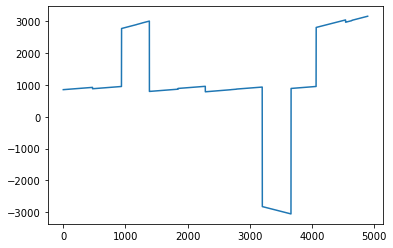

In [16]:
df['Depth'].plot()

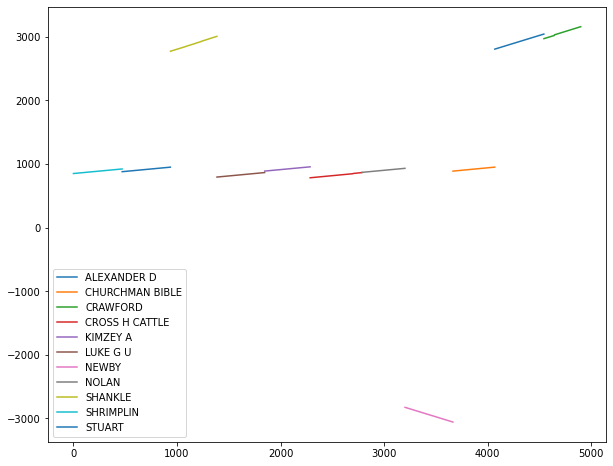

In [17]:
for name, grp in df.groupby('Well Name')['Depth']:
    grp.plot(label=name, legend=True, figsize=(10,8))

In [18]:
df['Depth'] = df['Depth'].abs()

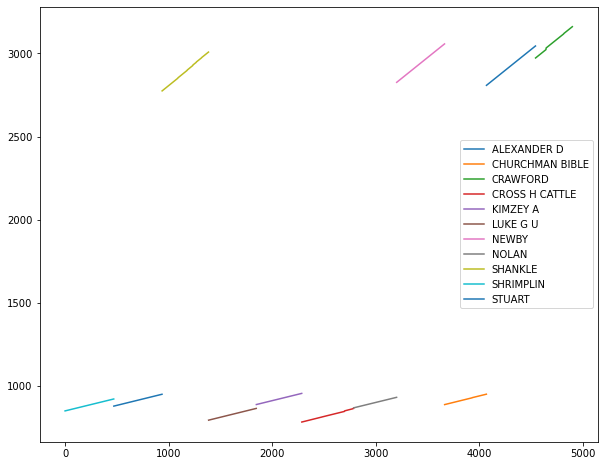

In [19]:
for name, grp in df.groupby('Well Name')['Depth']:
    grp.plot(label=name, legend=True, figsize=(10,8))

In [20]:
to_fix = ['SHANKLE', 'NEWBY', 'CRAWFORD', 'STUART']
df.loc[df['Well Name'].isin(to_fix), 'Depth'] = df['Depth'] * 0.3048

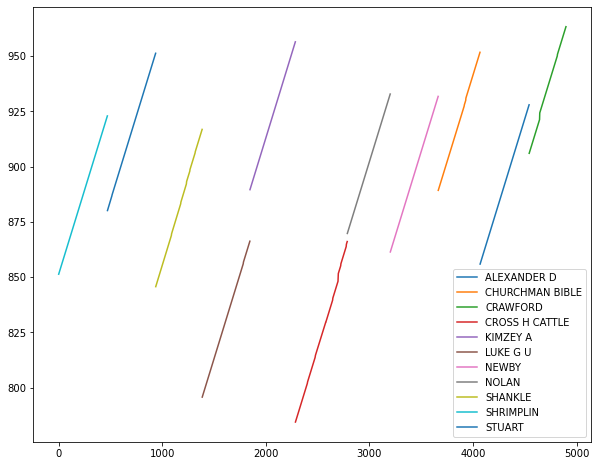

In [21]:
for name, grp in df.groupby('Well Name')['Depth']:
    grp.plot(label=name, legend=True, figsize=(10,8))

note for instructors:

#### `GR`, `ILD`, `DeltaPHI`

These are all fine for now. We will do more with them in the Feature Engineering step. Make a simple histplot and a line plot to verify that values are sensible, but there should not be any major changes at this point: the data are already good. We can also look at summary stats for a given column.

The **`PHIND`** column has something weird about it. A solution is shown below.

Two wells are missing **`PE`** values. We will drop these wells, since it is a feature we want to use.

### `GR`

<AxesSubplot:xlabel='GR', ylabel='Count'>

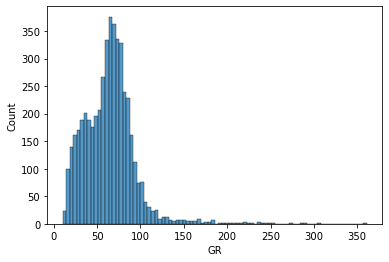

In [34]:
sns.histplot(df['GR'])

### `ILD`

### `DeltaPHI`

### `PHIND`

<AxesSubplot:xlabel='PHIND', ylabel='Count'>

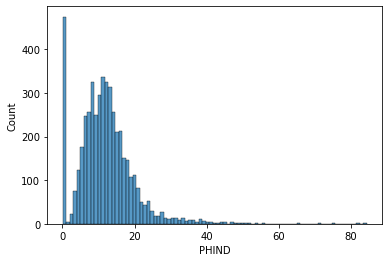

In [35]:
sns.histplot(df['PHIND'])

<AxesSubplot:>

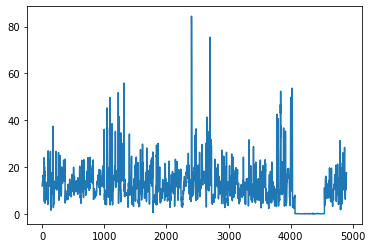

In [36]:
df['PHIND'].plot()

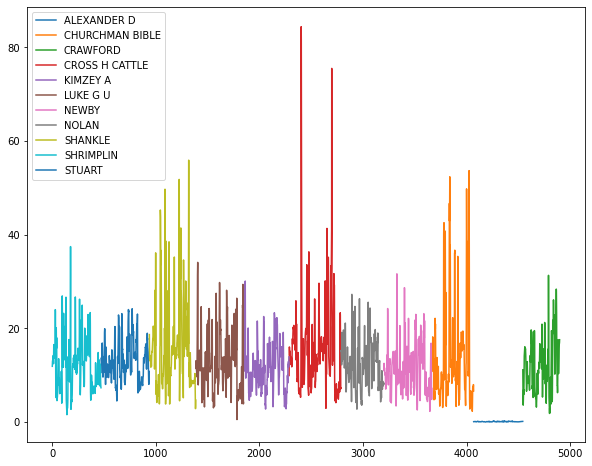

In [37]:
for name, grp in df.groupby('Well Name'):
    grp['PHIND'].plot(label=name, legend=True, figsize=(10,8))

In [38]:
df.loc[df['Well Name'] == 'STUART', 'PHIND'].describe()

count    474.000000
mean       0.113739
std        0.048097
min        0.025500
25%        0.077000
50%        0.107000
75%        0.137875
max        0.288500
Name: PHIND, dtype: float64

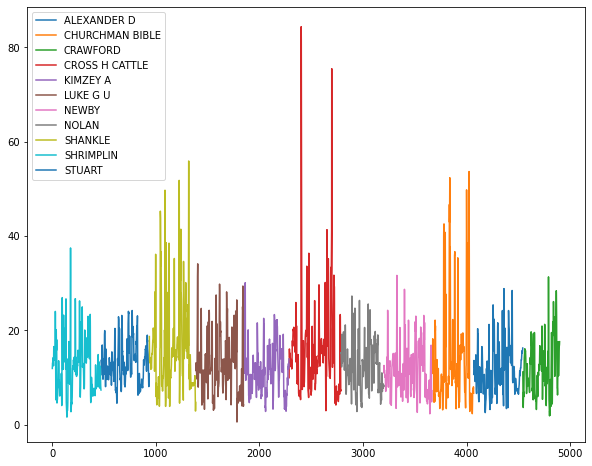

In [39]:
fixed_stuart_phi = df.loc[df['Well Name'] == 'STUART', 'PHIND'] * 100
df.loc[df['Well Name'] == 'STUART', 'PHIND'] = fixed_stuart_phi
for name, grp in df.groupby('Well Name'):
    grp['PHIND'].plot(label=name, legend=True, figsize=(10,8))

### `PE`

<AxesSubplot:>

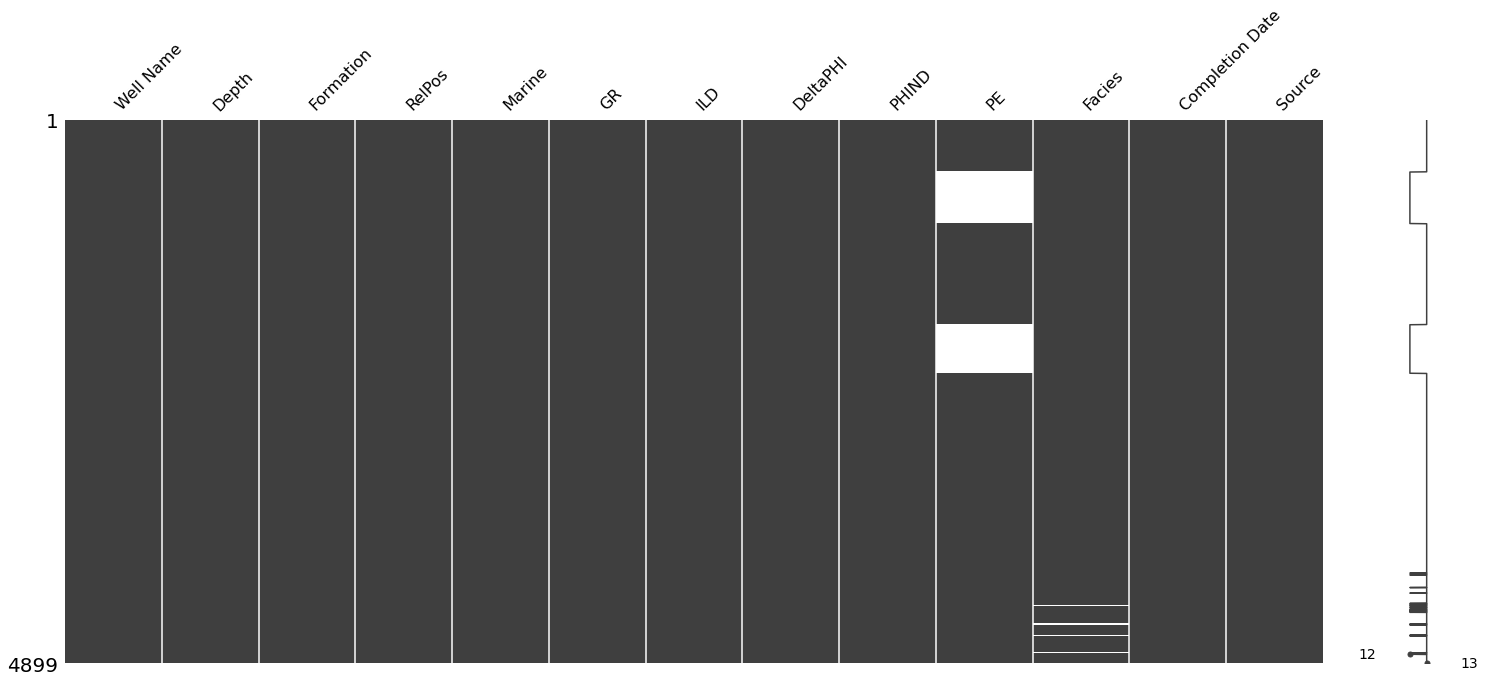

In [40]:
missingno.matrix(df)

In [41]:
# The Alexander D and Kimzey A are missing PE values.
df.loc[df['PE'].isna(), 'Well Name'].unique()

array(['ALEXANDER D', 'KIMZEY A'], dtype=object)

In [42]:
# They appear to not have _any_ PE values. 
df.loc[~df['PE'].isna(), 'Well Name'].unique()

array(['SHRIMPLIN', 'SHANKLE', 'LUKE G U', 'CROSS H CATTLE', 'NOLAN',
       'NEWBY', 'CHURCHMAN BIBLE', 'STUART', 'CRAWFORD'], dtype=object)

In [43]:
df = df.dropna(subset=['PE'])

In [44]:
df['Well Name'].unique()

array(['SHRIMPLIN', 'SHANKLE', 'LUKE G U', 'CROSS H CATTLE', 'NOLAN',
       'NEWBY', 'CHURCHMAN BIBLE', 'STUART', 'CRAWFORD'], dtype=object)

### `Facies`

In [45]:
# There are also NaNs in the Facies column:
df[df['Facies'].isna()]

,Well Name,Depth,Formation,RelPos,Marine,GR,ILD,DeltaPHI,PHIND,PE,Facies,Completion Date,Source
4085,STUART,858.3168,A1 SH,0.644,0,65.126,3.981072,3.300,10.550,2.914,NaN,Sun 03 Jun 2007,KGS
4101,STUART,860.7552,A1 SH,0.244,0,76.566,4.613176,10.700,11.550,3.381,NaN,Sun 03 Jun 2007,KGS
4215,STUART,878.1288,B1 SH,0.129,0,72.690,3.614099,4.800,18.500,2.969,NaN,Sun 03 Jun 2007,KGS
4265,STUART,885.7488,B2 SH,0.211,0,78.068,4.111497,5.000,18.100,3.252,NaN,Sun 03 Jun 2007,KGS
4358,STUART,899.9220,B4 LM,0.214,1,36.313,14.757065,-3.300,6.950,3.970,NaN,Sun 03 Jun 2007,KGS
4370,STUART,901.7508,B5 LM,0.854,1,25.957,1.552387,-2.400,19.900,4.294,NaN,Sun 03 Jun 2007,KGS
4381,STUART,903.4272,B5 LM,0.561,1,45.125,3.213661,2.300,8.450,4.248,NaN,Sun 03 Jun 2007,KGS
4395,STUART,905.5608,B5 LM,0.195,1,92.886,4.246196,-0.200,9.400,4.272,NaN,Sun 03 Jun 2007,KGS
4410,STUART,907.8468,C SH,0.814,0,79.896,2.864178,14.900,20.150,3.423,NaN,Sun 03 Jun 2007,KGS
4420,STUART,909.3708,C SH,0.558,0,81.895,2.697739,14.200,16.800,3.441,NaN,Sun 03 Jun 2007,KGS


In [46]:
df = df.dropna()

<AxesSubplot:>

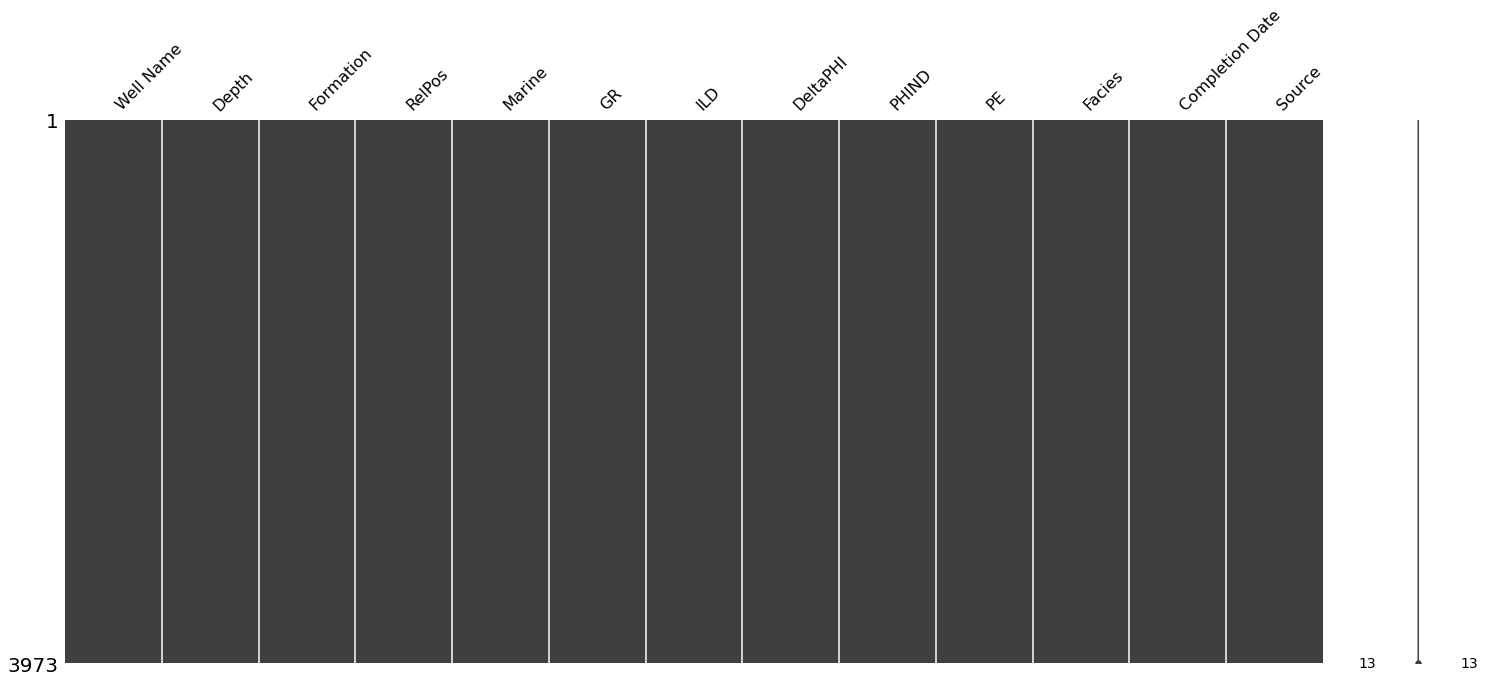

In [47]:
missingno.matrix(df)

### `Completion Date`

In [48]:
df['Completion Date'].dtype

dtype('O')

In [49]:
df['Completion Date'].unique()

array(['2010-03-26', 'Fri 13 Apr 2001', '2012-10-01', '2003-08-03',
       '2011-10-19', '2008-03-18', 'Fri 22 Dec 2006', 'Sun 03 Jun 2007',
       '2001-08-19'], dtype=object)

In [50]:
pd.to_datetime(df['Completion Date']).unique()

array(['2010-03-26T00:00:00.000000000', '2001-04-13T00:00:00.000000000',
       '2012-10-01T00:00:00.000000000', '2003-08-03T00:00:00.000000000',
       '2011-10-19T00:00:00.000000000', '2008-03-18T00:00:00.000000000',
       '2006-12-22T00:00:00.000000000', '2007-06-03T00:00:00.000000000',
       '2001-08-19T00:00:00.000000000'], dtype='datetime64[ns]')

In [51]:
df['Completion Date'] = pd.to_datetime(df['Completion Date'])
df['Completion Date'].dtype

dtype('<M8[ns]')

### `Source`

In [52]:
df['Source'].unique()

array(['KGS'], dtype=object)

In [53]:
df = df.drop(columns=['Source'])

## Saving our cleaned data out

We have many options for saving our data out. The [docs have a full list](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html).

The easiest is probably a csv, since that is what we read in, but we could do other things as well.

In [54]:
df.to_csv('../data/Panoma_Field_Permian.csv', index=False, )

This might be good to show again:

If we are comfortable with SQL, or have an existing database, we may wish to write our dataframe as a table there. We will use [sqlite3](https://docs.python.org/3/library/sqlite3.html). If you have an existing database you may prefer to look at [SQLalchemy](https://docs.sqlalchemy.org/) to create the connection instead:

In [55]:
import sqlite3

In [56]:
connection = sqlite3.connect('../data/panoma.db')
df.to_sql('panoma_cleaned', con=connection, if_exists='replace', index=False)

3973

At this point, it might be worth showing that you can read from a sqlite `.db` file using the following pattern:

```python
sql_command = '''SELECT *
FROM panoma_cleaned
'''

pd.read_sql(sql_command, con=conn)
```
We can also do something more complex, like only retrieve specific columns, if records match specific conditions:
```python
sql_command = '''SELECT [well name], depth, pe, gr, phind
FROM panoma_cleaned
WHERE [Well Name] IN ('SHRIMPLIN', 'CHURCHMAN BIBLE') AND Depth > 890 AND Depth < 900
'''

pd.read_sql(sql_command, con=conn)
```

<hr />

<p style="color:gray">©2022 Agile Geoscience. Licensed CC-BY.</p>